Importind the data set from kaggle:[link text](https:/https://www.kaggle.com/datasets/tschandl/isic2018-challenge-task1-data-segmentation//)

isic2018-challenge-task1-data-segmentation

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tschandl/isic2018-challenge-task1-data-segmentation")

print("Path to dataset files:", path)

100%|██████████| 12.9G/12.9G [02:27<00:00, 93.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tschandl/isic2018-challenge-task1-data-segmentation/versions/1


In [2]:
!ls /root/.cache/kagglehub/datasets/tschandl/isic2018-challenge-task1-data-segmentation/versions/1/

ISIC2018_Task1-2_Test_Input	 ISIC2018_Task1-2_Validation_Input
ISIC2018_Task1-2_Training_Input  ISIC2018_Task1_Training_GroundTruth


We only use files ending with .jpg or segmentation.png

In [14]:
import os
from sklearn.model_selection import train_test_split

# Paths to training data
base_path = "/root/.cache/kagglehub/datasets/tschandl/isic2018-challenge-task1-data-segmentation/versions/1"
img_dir = os.path.join(base_path, "ISIC2018_Task1-2_Training_Input")
mask_dir = os.path.join(base_path, "ISIC2018_Task1_Training_GroundTruth")

# Get filenames (without extension)
'''
img_files = sorted(os.listdir(img_dir))
mask_files = sorted(os.listdir(mask_dir))
'''

# Getting file names
img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith("_segmentation.png")])

# matching the names of the data with its mask
img_ids = [os.path.splitext(f)[0] for f in img_files if f.replace(".jpg", "_segmentation.png") in mask_files]
img_ids = [os.path.splitext(f)[0] for f in img_files]

# Split into train and val
train_ids, val_ids = train_test_split(img_ids, test_size=0.2, random_state=42)

print("Training samples:", len(train_ids))
print("Validation samples:", len(val_ids))


Training samples: 2075
Validation samples: 519


Ploting some ramdom samples

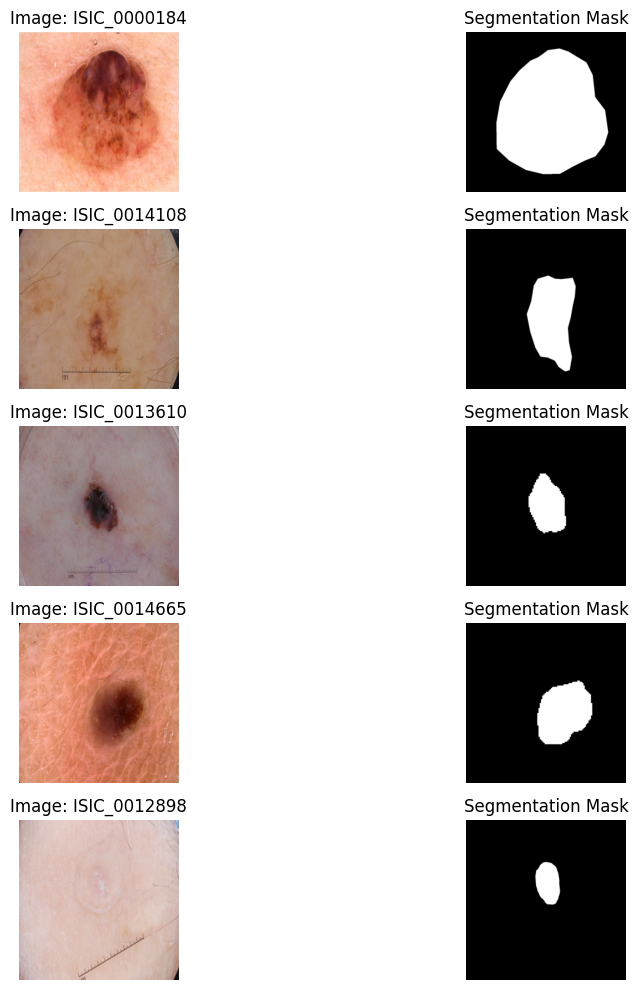

In [28]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import os


img_ids = [os.path.splitext(f)[0] for f in os.listdir(img_dir)]


# Pick 5 random samples
sample_ids = random.sample(img_ids, 5)

# code to Plot the pic
plt.figure(figsize=(12, 10))

for i, img_id in enumerate(sample_ids):
    # Load image and mask
    img_path = os.path.join(img_dir, img_id + ".jpg")
    mask_path = os.path.join(mask_dir, img_id + "_segmentation.png")

    image = Image.open(img_path).resize((256, 256))
    mask = Image.open(mask_path).resize((256, 256))

    # Show image
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(image)
    plt.title(f"Image: {img_id}")
    plt.axis('off')

    # Show mask
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Segmentation Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [16]:
# Image and mask dimensions (you can change this)

IMG_SIZE = 64

Utilitiz for data preproccessing and creating the TF datsets

We did not perform data augmentation due to GPU limitations, and the original dataset size was sufficient to achieve acceptable results.

In [29]:
import tensorflow as tf
import os


def process_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0

    # Read mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # Mask is grayscale
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE])
    mask = tf.cast(mask, tf.float32) / 255.0  # Normalize to [0, 1]
    mask = tf.round(mask)  # Ensure binary (0 or 1)

    return image, mask

# Function to create tf.data.Dataset from a list of IDs
def create_dataset(ids, img_dir, mask_dir, batch_size=16, shuffle=True):
    image_paths = [os.path.join(img_dir, id_ + ".jpg") for id_ in ids]
    mask_paths = [os.path.join(mask_dir, id_ + "_segmentation.png") for id_ in ids]

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=100)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


In [18]:
train_dataset = create_dataset(train_ids, img_dir, mask_dir, batch_size=8, shuffle=True)
val_dataset = create_dataset(val_ids, img_dir, mask_dir, batch_size=8, shuffle=False)


**MODEL**

A U_net training with no transfer learning or pretrained model encoders

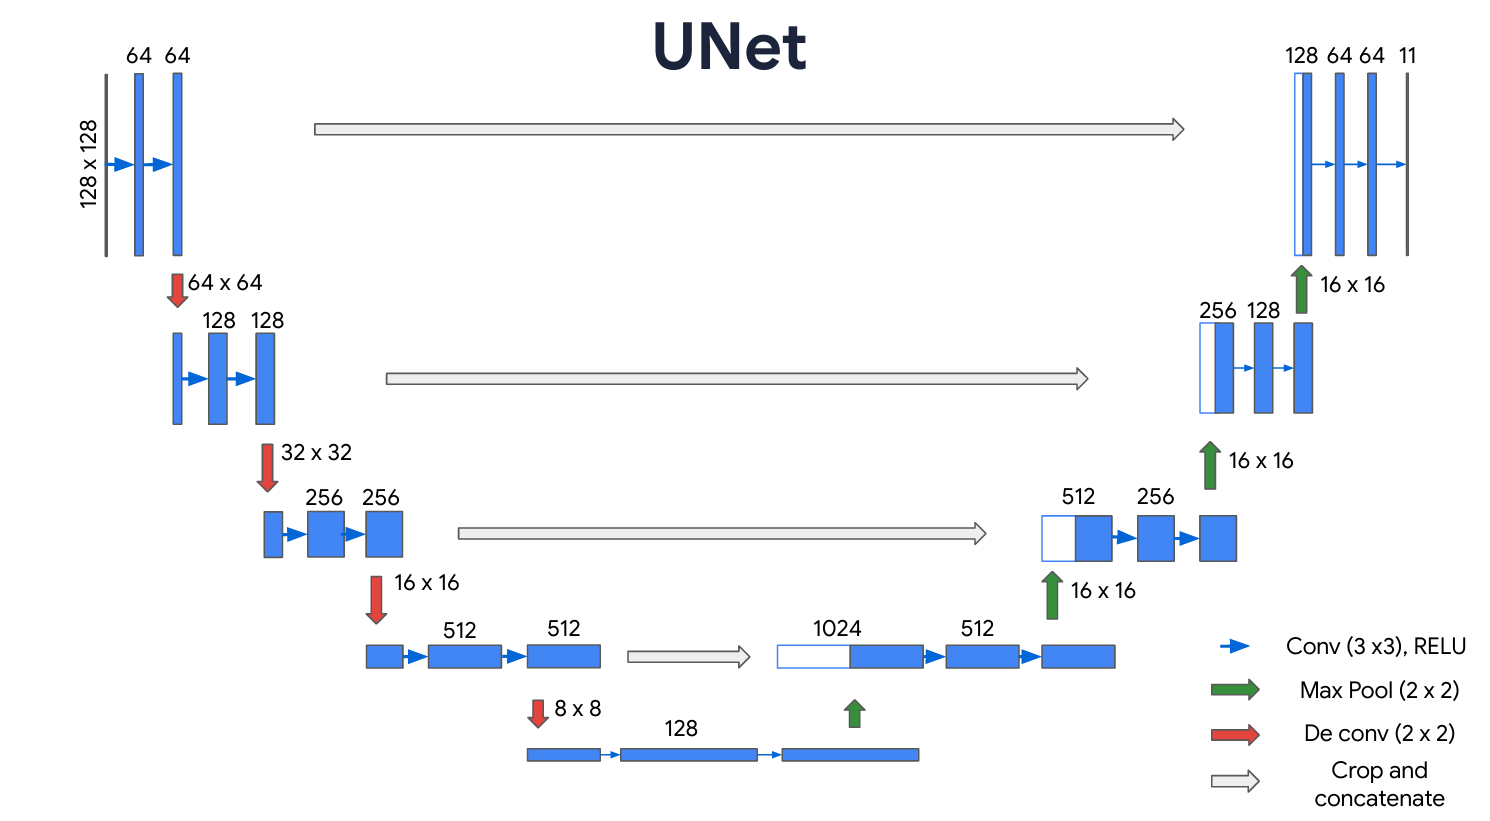

In [19]:
# Encoder Utilties

def conv2d_block(input_tensor, n_filters, kernel_size=3):

  # first layer
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
                               kernel_initializer="he_normal", padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)

  return x
def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):

  # the f (conv outputs will be used for our skep connections to de decoder as it is shown in the picture)
  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPool2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p

def encoder(inputs):

  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2, 2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2, 2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2, 2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2, 2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

In [20]:
def bottleneck(inputs):


  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

In [21]:
# Decoder Utilities

def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):

  u = tf.keras.layers.Conv2DTranspose(filters=n_filters, kernel_size=kernel_size,
                                      strides=strides, padding="same")(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters=n_filters, kernel_size=3)

  return c

def decoder(inputs, convs, output_channels):


  f1, f2, f3, f4 = convs
  # 5 is the bottleneck if you ask
  c6 = decoder_block(inputs, conv_output=f4, n_filters=512, kernel_size=(3,3),
                     strides=(2,2), dropout=0.3)

  c7 = decoder_block(c6, conv_output=f3, n_filters=256, kernel_size=(3,3),
                     strides=(2,2), dropout=0.3)

  c8 = decoder_block(c7, conv_output=f2, n_filters=128, kernel_size=(3,3),
                     strides=(2,2), dropout=0.3)

  c9 = decoder_block(c8, conv_output=f1, n_filters=64, kernel_size=(3,3),
                     strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1,1), activation="softmax")(c9)##########

  return outputs

In [22]:
OUTPUT_CHANNELS = 3

def unet():
  """
  Defines the UNet by connecting the encoder, bottleneck and decoder.
  """


  inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3,))
  encoder_output, convs = encoder(inputs)
  bottle_neck = bottleneck(encoder_output)
  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model


model = unet()

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [24]:
EPOCHS = 10

# train the model
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          validation_data=val_dataset)

Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - accuracy: 0.8189 - loss: 0.4859 - val_accuracy: 0.8683 - val_loss: 0.3366
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - accuracy: 0.8758 - loss: 0.3230 - val_accuracy: 0.8785 - val_loss: 0.3035
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 280s 1s/step - accuracy: 0.8862 - loss: 0.3029 - val_accuracy: 0.8944 - val_loss: 0.2856
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.9067 - loss: 0.2532 - val_accuracy: 0.9139 - val_loss: 0.2279
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 301s 1s/step - accuracy: 0.9203 - loss: 0.2124 - val_accuracy: 0.9175 - val_loss: 0.2131
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.9245 - loss: 0.1995 - val_accuracy: 0.9247 - val_loss: 0.1982
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - accuracy: 0.9276 - loss: 0.1866 - val_accuracy: 0.9247 - val_loss: 0.1991
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.9310 - loss: 0.1760 - val_accu

In [25]:
def iou_metric(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)

    return tf.reduce_mean(iou)

In [26]:
def dice_coefficient(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    dice = (2. * intersection + 1e-7) / (tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) + 1e-7)

    return tf.reduce_mean(dice)

In [27]:
# Collect predictions and ground truths
all_preds = []
all_labels = []

for images, masks in val_dataset:
    preds = model.predict(images)
    all_preds.append(preds)
    all_labels.append(masks)

# Concatenate all batches
all_preds = tf.concat(all_preds, axis=0)
all_labels = tf.concat(all_labels, axis=0)

# Compute metrics
iou_score = iou_metric(all_labels, all_preds).numpy()
dice_score = dice_coefficient(all_labels, all_preds).numpy()

print(f"IoU Score: {iou_score:.4f}")
print(f"Dice Coefficient: {dice_score:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


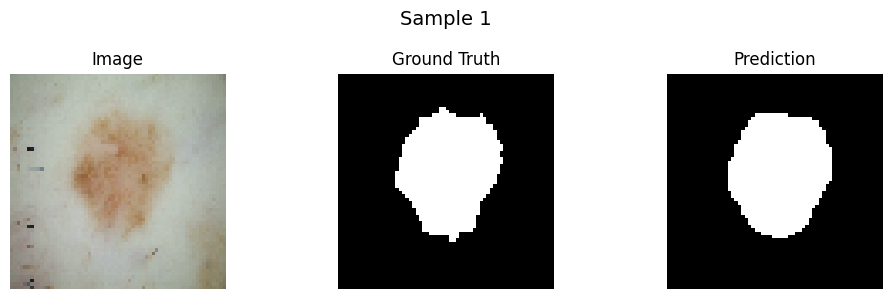

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


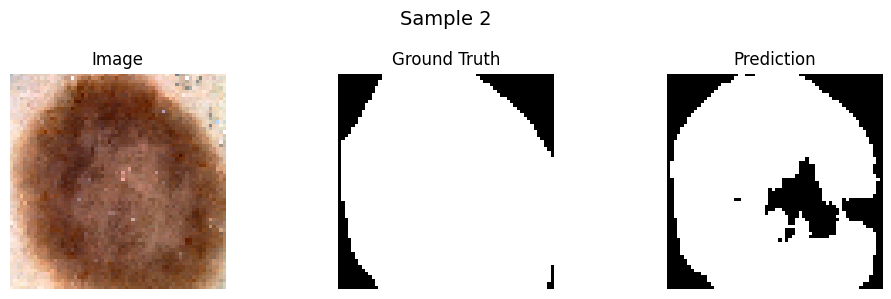

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


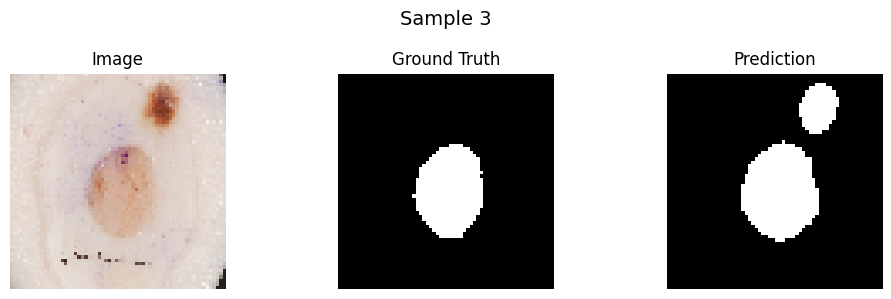

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


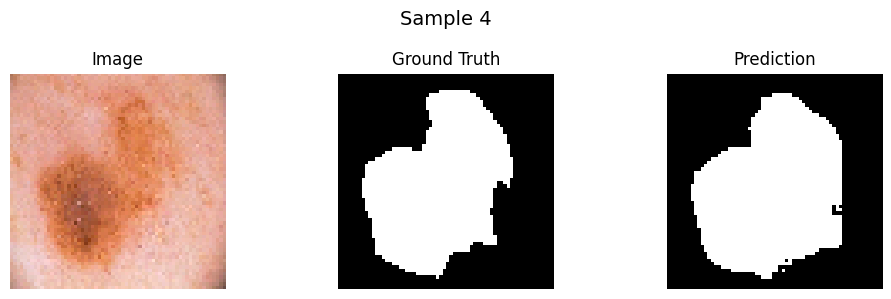

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


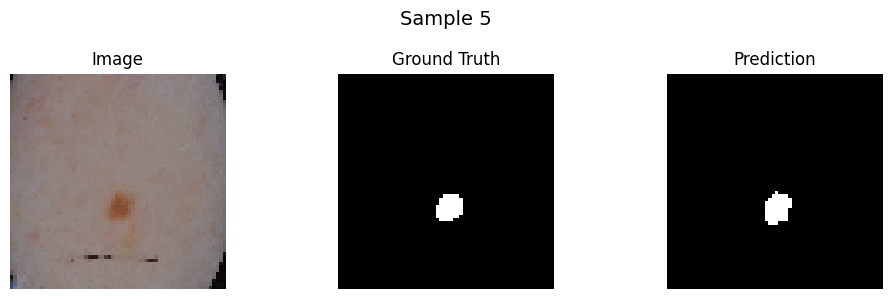

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


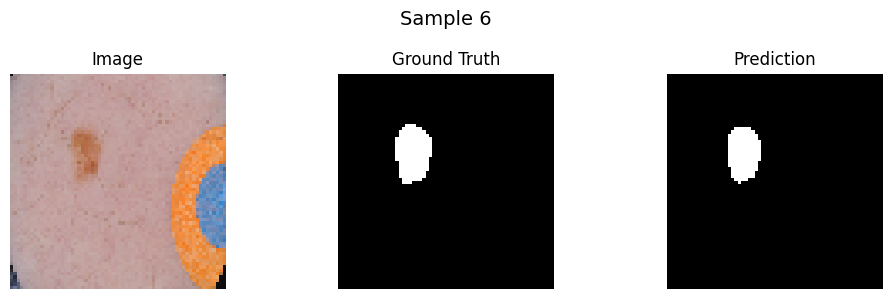

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


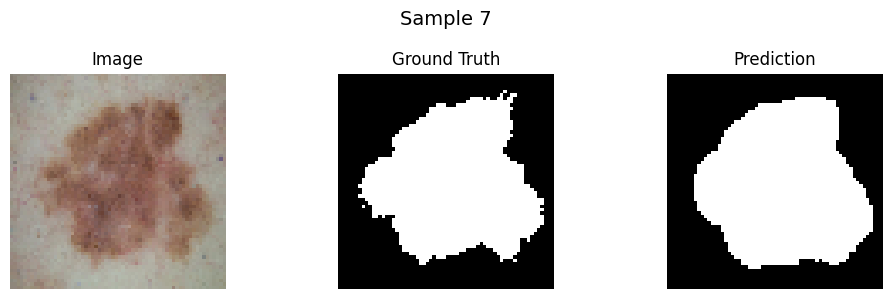

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


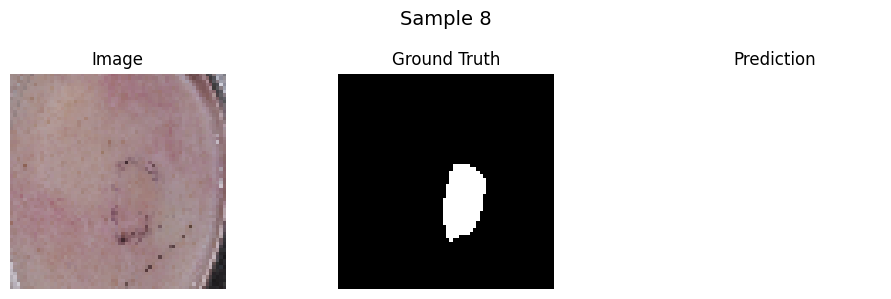

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


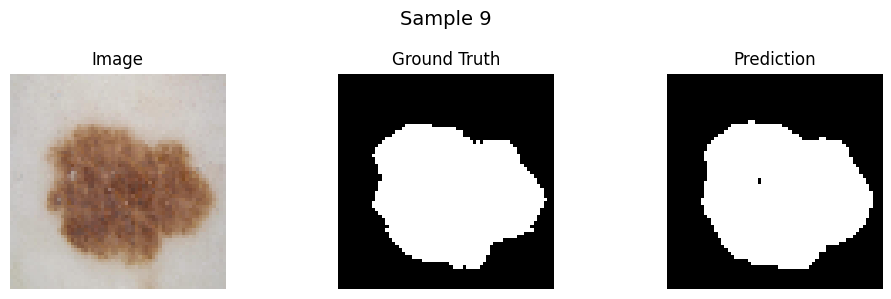

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


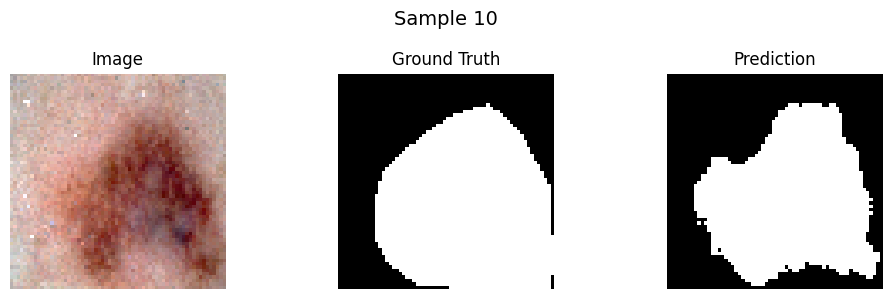

In [32]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array



# Pick 10 random validation IDs
sample_ids = random.sample(val_ids, 10)

def preprocess_image_mask(img_path, mask_path):
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img = img_to_array(img) / 255.0  # normalize to [0, 1]

    mask = load_img(mask_path, target_size=(IMG_SIZE,IMG_SIZE), color_mode='grayscale')
    mask = img_to_array(mask) / 255.0  # normalize to [0, 1]
    return img, mask

def plot_prediction(img, true_mask, pred_mask, i):
    plt.figure(figsize=(10, 3))
    plt.suptitle(f"Sample {i+1}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask[:, :, 0], cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray_r')
    plt.title("Prediction")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Loop through the samples
for i, sample_id in enumerate(sample_ids):
    img_path = os.path.join(img_dir, sample_id + ".jpg")
    mask_path = os.path.join(mask_dir, sample_id + "_segmentation.png")

    img, true_mask = preprocess_image_mask(img_path, mask_path)
    input_img = np.expand_dims(img, axis=0)  # add batch dim

    # Predict
    pred_mask = model.predict(input_img)[0, :, :, 0]  # remove batch + channel
    pred_mask = (pred_mask > 0.5).astype(np.float32)  # threshold

    plot_prediction(img, true_mask, pred_mask, i)
